In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping

In [9]:
df = pd.read_csv('/content/updated_data.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset Shape: (321584, 8)

Dataset Shape: (321584, 8)

First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_content  silt_content  \
0  2013-01-03    54.875      9.125           5.0          86.0           9.0   
1  2013-01-05    54.875      9.125           5.0          86.0           9.0   
2  2013-01-07    54.875      9.125           5.0          86.0           9.0   
3  2013-01-08    54.875      9.125           5.0          86.0           9.0   
4  2013-01-09    54.875      9.125           5.0          86.0           9.0   

     sm_aux  sm_tgt  
0  0.454120    0.53  
1  0.437102    0.44  
2  0.412978    0.42  
3  0.378734    0.55  
4  0.350740    0.46  

Missing values in each column:
time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

Dataset Shape: (321584, 8)

First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_

In [10]:
unique_locations =df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(f"There are {unique_locations.shape[0]} unique locations in the dataset")

There are 1166 unique locations in the dataset


In [15]:
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap", width=800, height=800)

m

In [17]:
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()
start_date = df['time'].min()
end_date = df['time'].max()
print(f"The time series starts on {start_date} and ends on {end_date}.")

The time series starts on 2013-01-01 and ends on 2013-12-31.


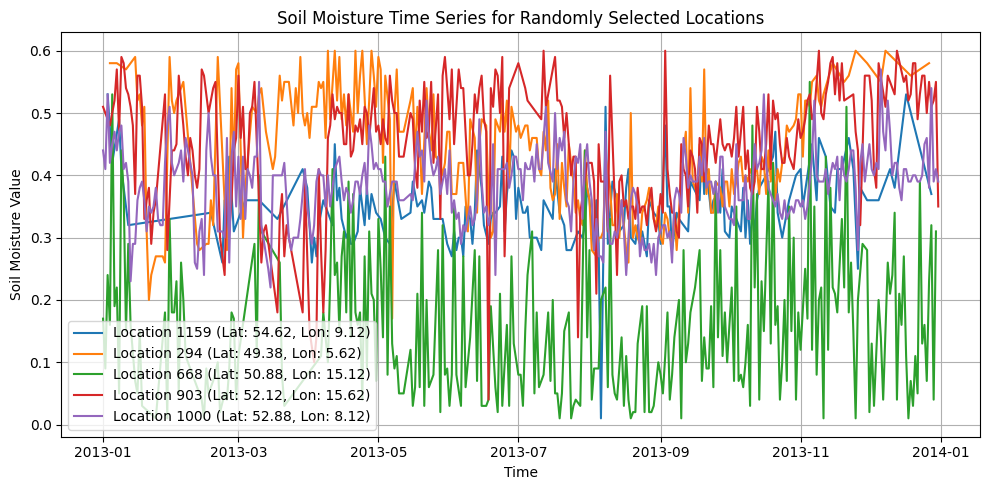

In [18]:
random_locations = np.random.choice(df['location_id'].unique(), 5, replace=False)

plt.figure(figsize=(10, 5))
for location in random_locations:
  subset = df[df['location_id'] == location]
  lat = subset['latitude'].iloc[0]
  lon = subset['longitude'].iloc[0]
  plt.plot(pd.to_datetime(subset['time']), subset['sm_tgt'], label=f"Location {location} (Lat: {lat:.2f}, Lon: {lon:.2f})")

plt.title("Soil Moisture Time Series for Randomly Selected Locations")
plt.xlabel("Time")
plt.ylabel("Soil Moisture Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

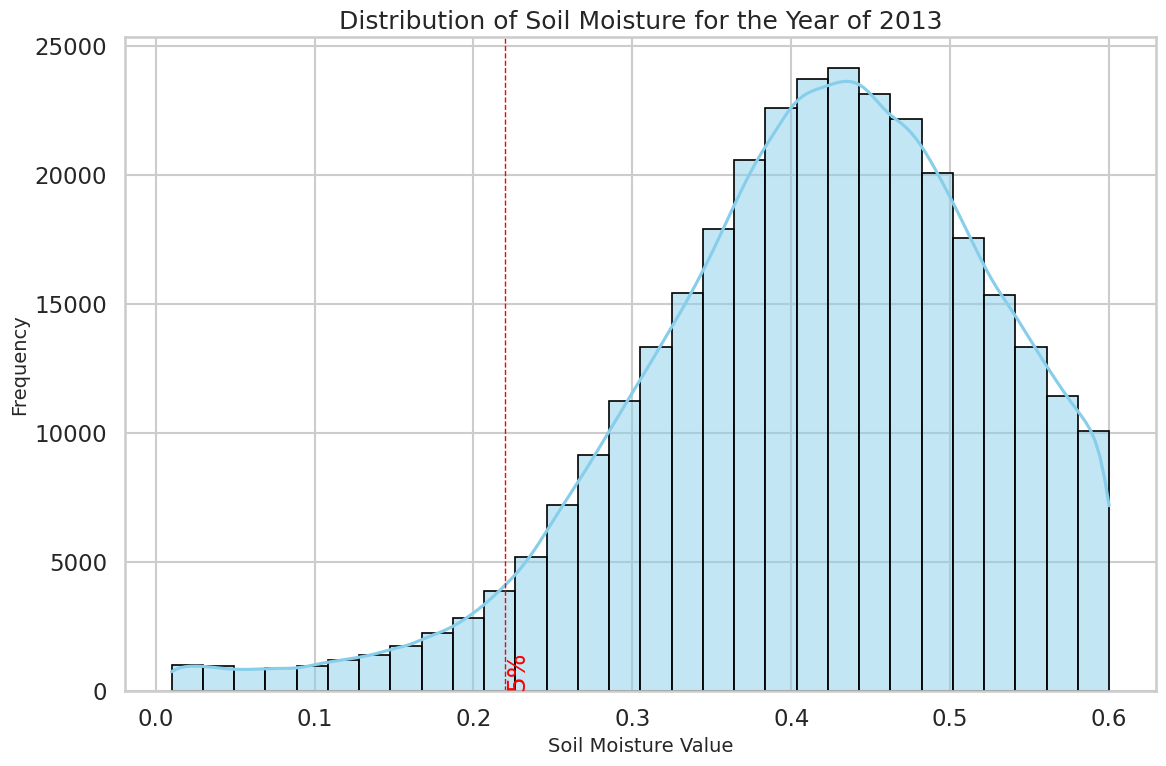

<ipython-input-19-554e073c633a>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


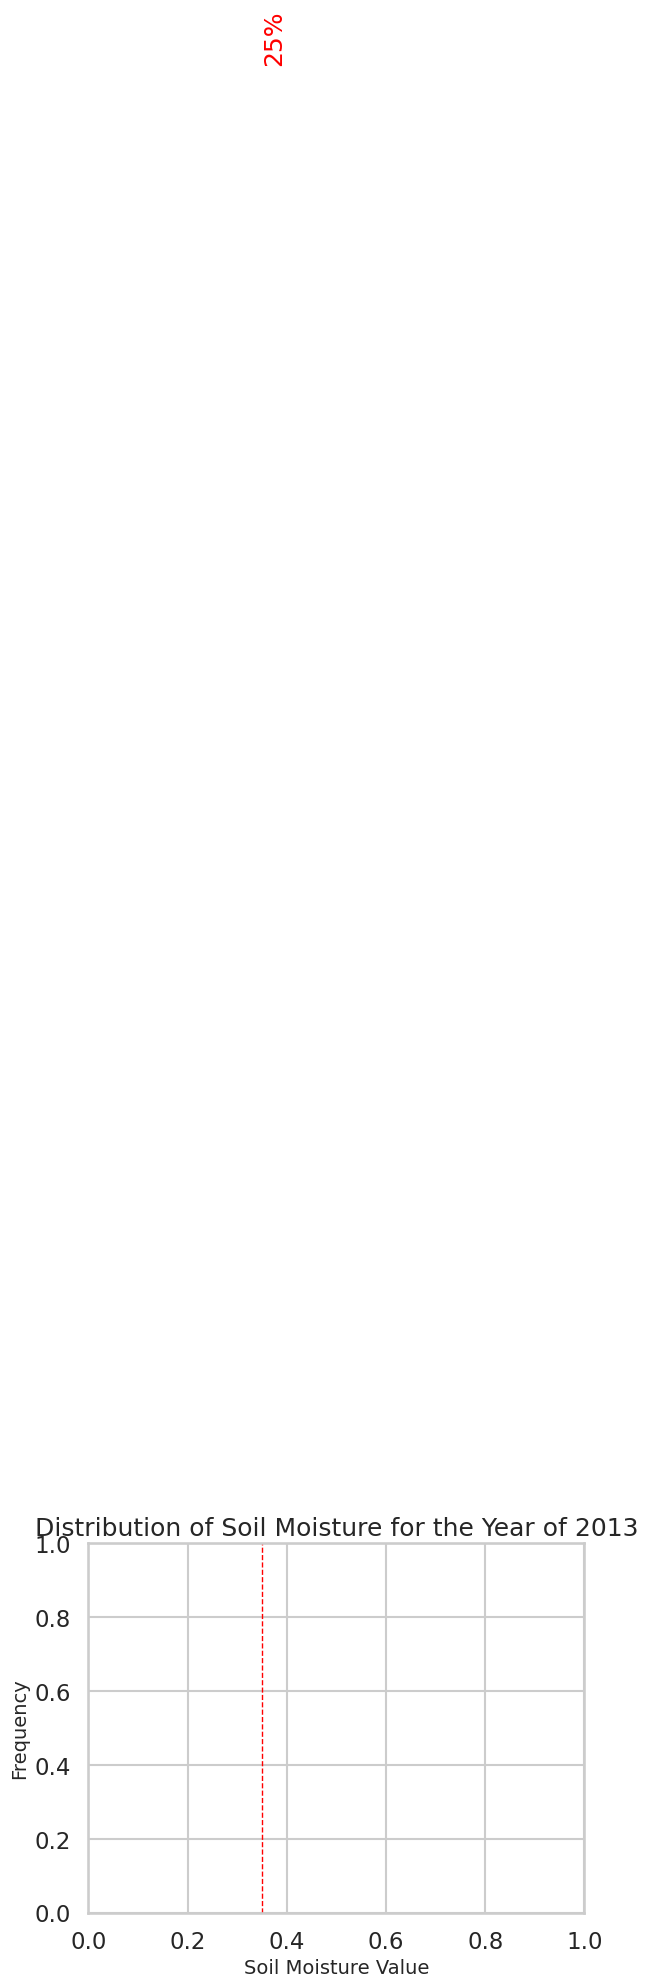

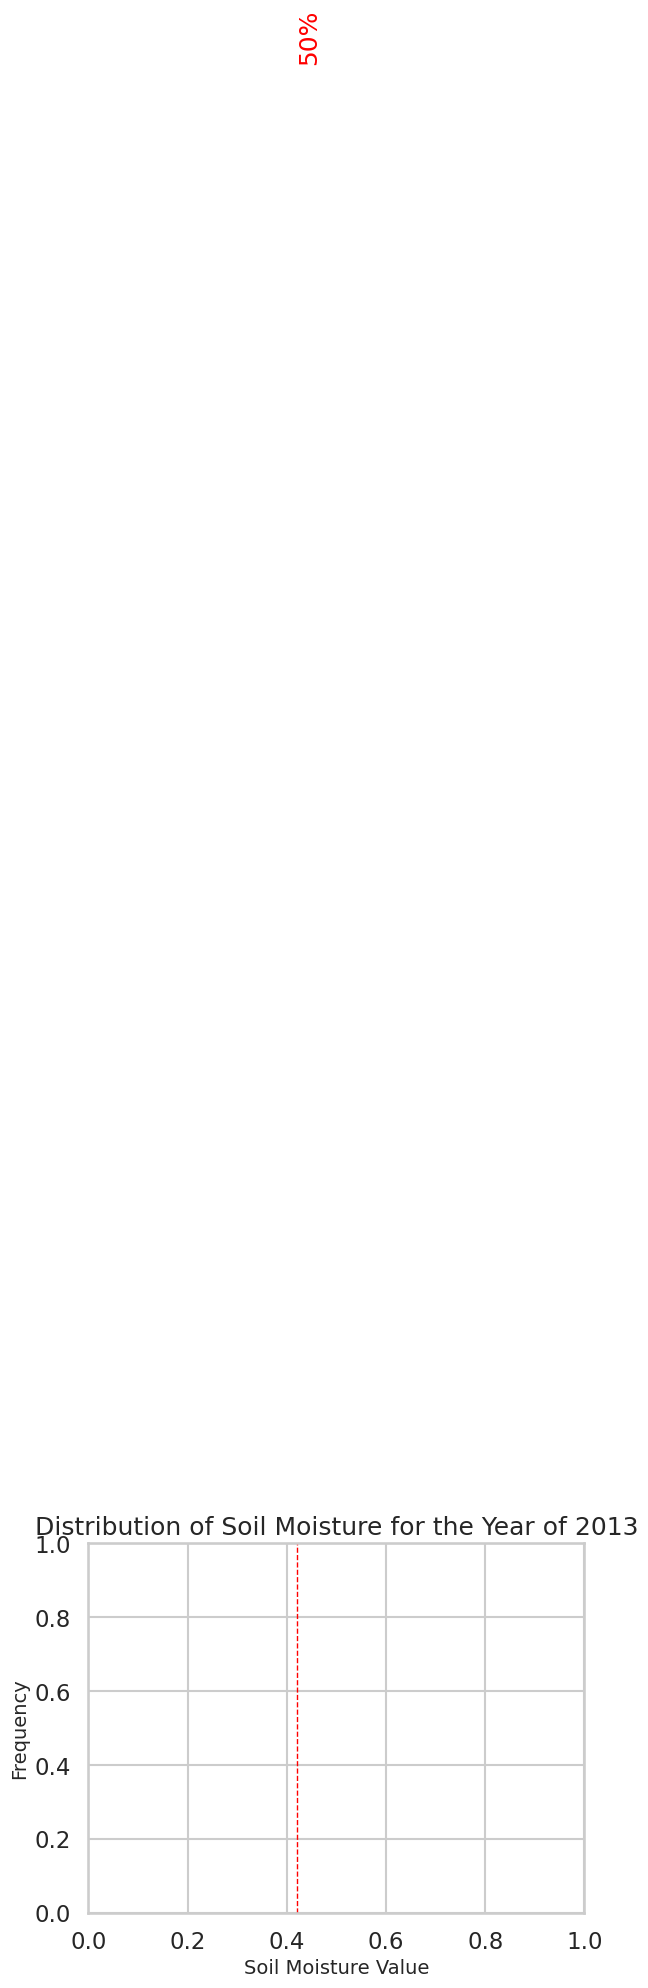

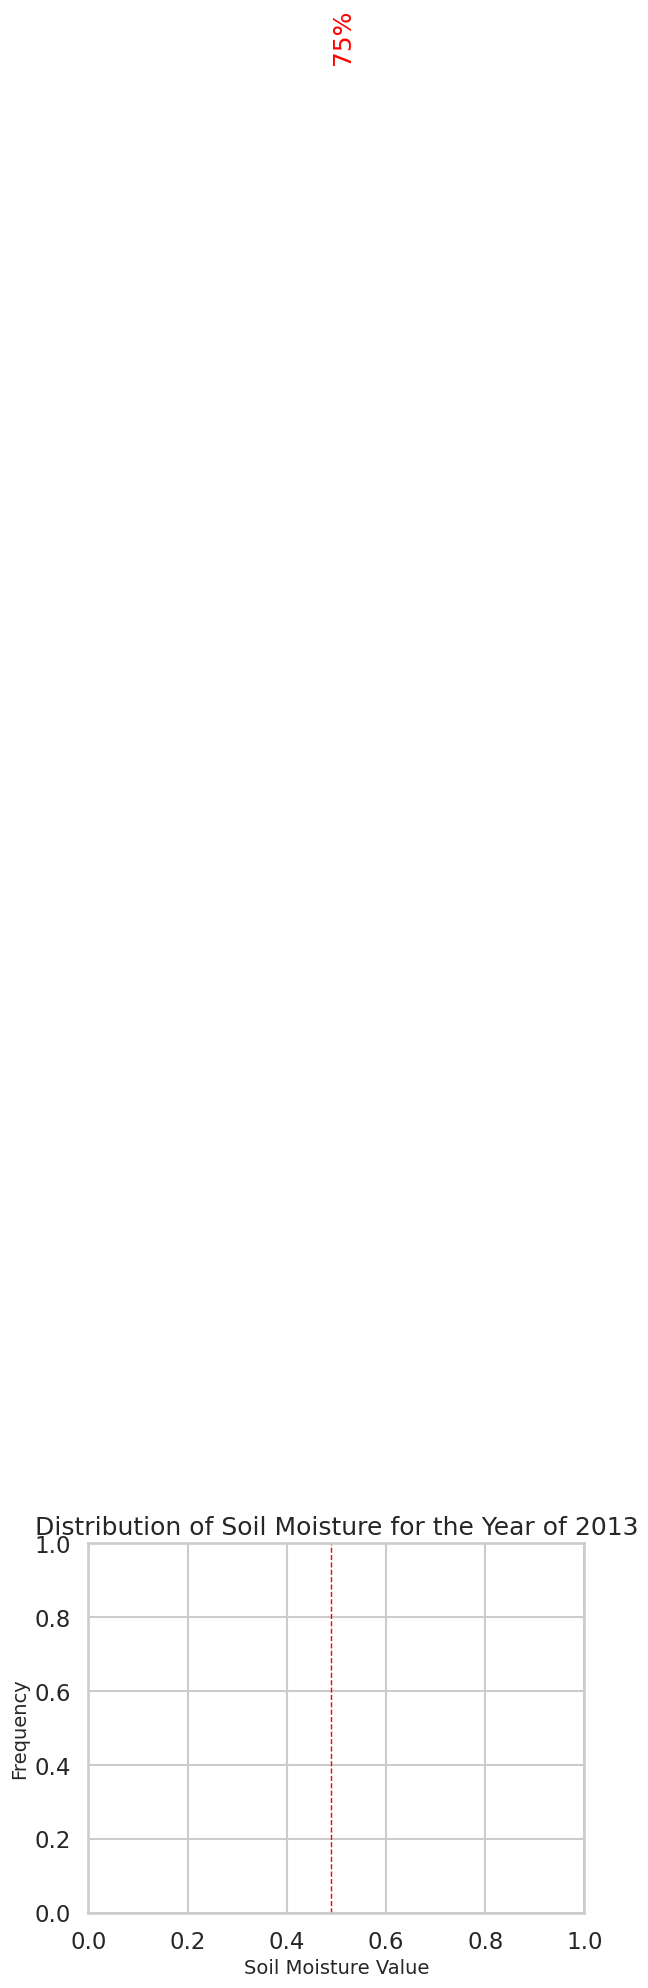

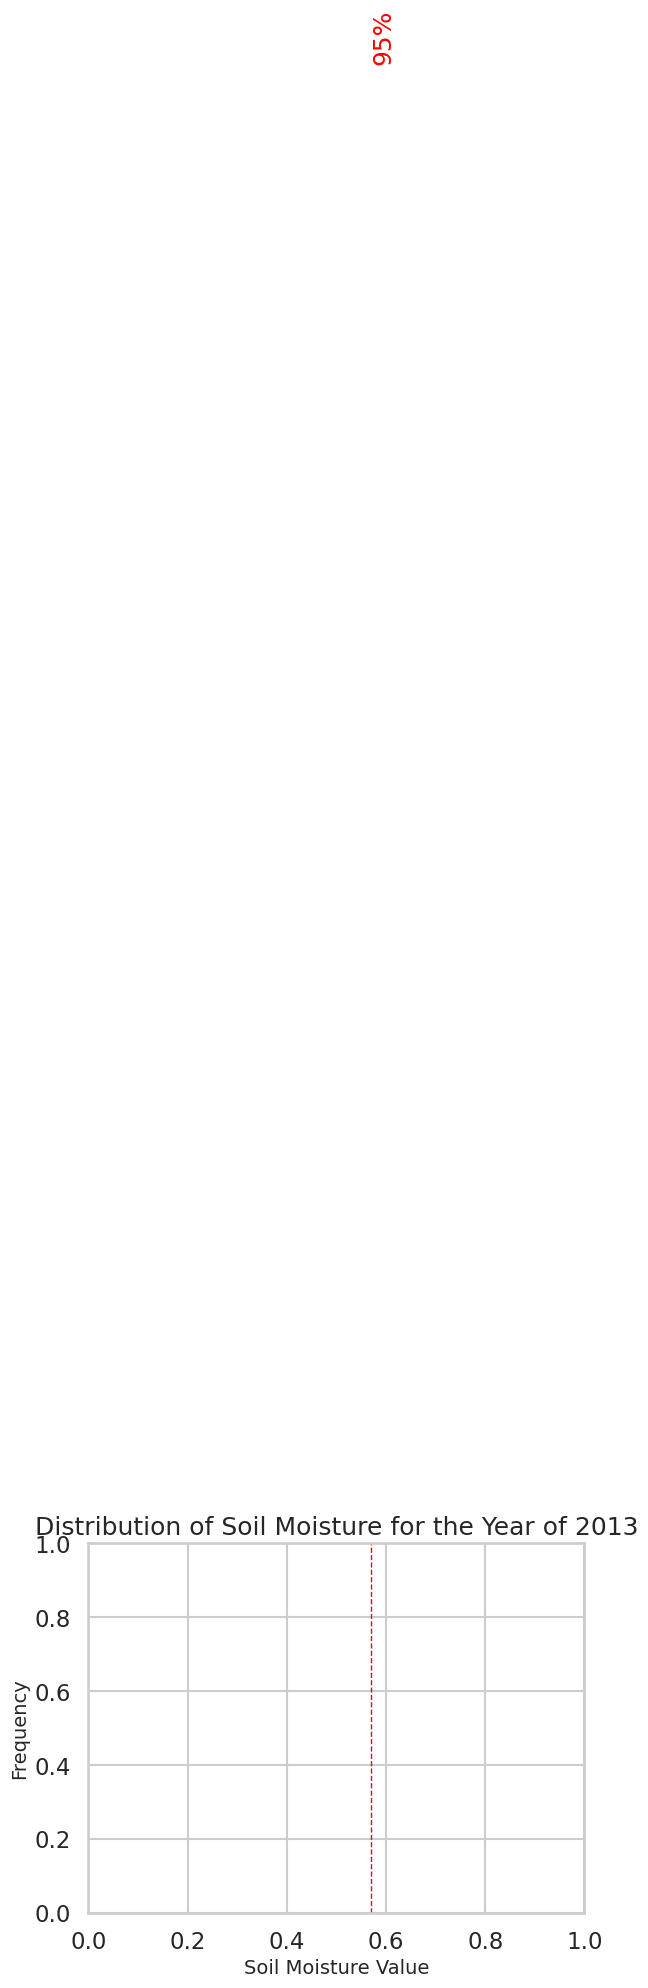

In [19]:
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(12, 8))
sns.histplot(df['sm_tgt'], kde=True, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)

percentiles = [5, 25, 50, 75, 95]
for percentile in percentiles:
  value = np.percentile(df['sm_tgt'], percentile)
  plt.axvline(value, color='red', linestyle='dashed', linewidth=1)
  plt.text(value, 5, f'{percentile}%', color='red', rotation=90, verticalalignment='bottom')

  plt.title("Distribution of Soil Moisture for the Year of 2013", fontsize=18)
  plt.xlabel("Soil Moisture Value", fontsize=14)
  plt.ylabel("Frequency", fontsize=14)

  plt.tight_layout()
  plt.show()

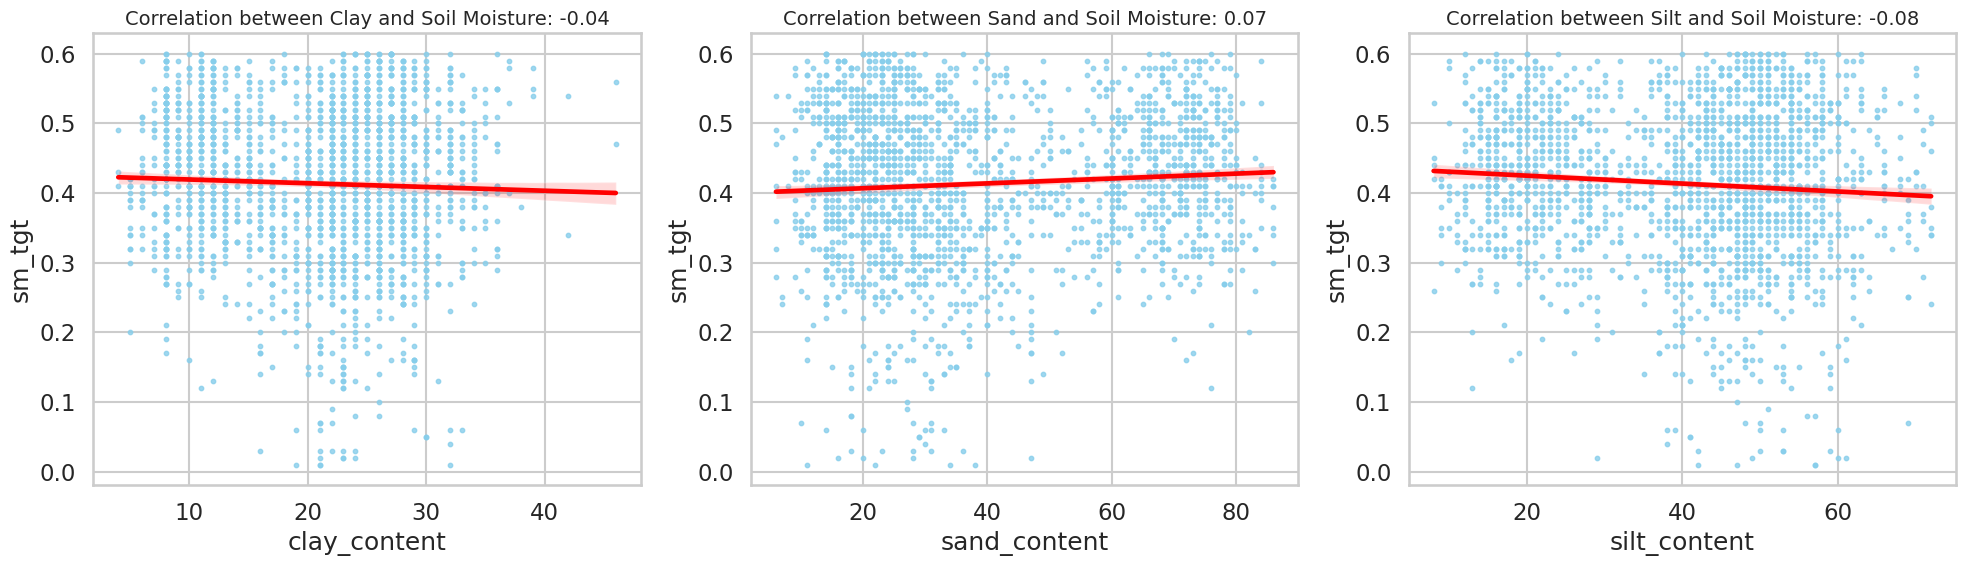

In [22]:
# Randomly sample 2000 data points from the dataframe
sample_df = df.sample(n=2000, random_state=42)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
sns.set_context("talk")

# Initialize a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# List of soil components
components = ['clay_content', 'sand_content', 'silt_content']

# Plot scatter plots for each component
for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_tgt', data=sample_df, ax=axes[i], color='skyblue', scatter_kws={'s':10}, line_kws={'color':'red'})

    # Calculate correlation and annotate the plot with its value
    correlation = sample_df[component].corr(sample_df['sm_tgt'])
    axes[i].set_title(f"Correlation between {component.split('_')[0].capitalize()} and Soil Moisture: {correlation:.2f}", fontsize=14)

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [23]:
df['time'] = pd.to_datetime(df['time'])

june_data = df[df['time'].dt.month == 6]

df = df[df['time'].dt.month != 6]

june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt,location_id
96,2013-06-01,54.875,9.125,5.0,86.0,9.0,0.132296,0.35,1163
97,2013-06-02,54.875,9.125,5.0,86.0,9.0,0.111909,0.31,1163
98,2013-06-03,54.875,9.125,5.0,86.0,9.0,0.099585,0.32,1163
99,2013-06-04,54.875,9.125,5.0,86.0,9.0,0.081596,0.32,1163
100,2013-06-05,54.875,9.125,5.0,86.0,9.0,0.098436,0.31,1163


In [24]:
features_to_normalize = ['latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']

scaler = MinMaxScaler()

df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
june_data[features_to_normalize] = scaler.transform(june_data[features_to_normalize])

ordered_columns = ['time', 'latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
df = df[ordered_columns]
june_data = june_data[ordered_columns]

df.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
0,2013-01-03,1.0,0.509091,0.02381,1.0,0.015625,0.585957,0.999141,0.881356
1,2013-01-05,1.0,0.509091,0.02381,1.0,0.015625,0.565721,0.999141,0.728814
2,2013-01-07,1.0,0.509091,0.02381,1.0,0.015625,0.537036,0.999141,0.694915
3,2013-01-08,1.0,0.509091,0.02381,1.0,0.015625,0.496316,0.999141,0.915254
4,2013-01-09,1.0,0.509091,0.02381,1.0,0.015625,0.463029,0.999141,0.762712


In [25]:
june_data.head()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,location_id,sm_tgt
96,2013-06-01,1.0,0.509091,0.02381,1.0,0.015625,0.203279,0.999141,0.576271
97,2013-06-02,1.0,0.509091,0.02381,1.0,0.015625,0.179037,0.999141,0.508475
98,2013-06-03,1.0,0.509091,0.02381,1.0,0.015625,0.164383,0.999141,0.525424
99,2013-06-04,1.0,0.509091,0.02381,1.0,0.015625,0.142992,0.999141,0.525424
100,2013-06-05,1.0,0.509091,0.02381,1.0,0.015625,0.163016,0.999141,0.508475


In [27]:
data_points_per_location = june_data.groupby('location_id').size()

locations_to_exclude = data_points_per_location[data_points_per_location < 15].index

june_data = june_data[~june_data['location_id'].isin(locations_to_exclude)]

In [29]:
def create_sequences(data, seq_length):
  X, Y = [], []

  for location, group in data.groupby('location_id'):
    features = group[features_to_normalize].drop(columns='sm_tgt').values
    targets = group['sm_tgt'].values

    for i in range(len(features) - seq_length):
      X.append(features[i:i+seq_length])
      Y.append(targets[i+seq_length])

    return X, Y

seq_length = 15

X, Y = create_sequences(df, seq_length)

X = np.array(X)
Y = np.array(Y)

X.shape, Y.shape

((260, 15, 7), (260,))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - loss: 1.3414 - val_loss: 1.5834
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 1.2507 - val_loss: 1.4928
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 1.1723 - val_loss: 1.4072
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 1.1093 - val_loss: 1.3282
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 1.0361 - val_loss: 1.2516
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.9715 - val_loss: 1.1778
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.9193 - val_loss: 1.1068
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.8560 - val_loss: 1.0397
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.8028 - val_loss: 0.9745
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.7470 - val_loss: 0.9107
Restoring model weights from the end of the best epoch: 10.


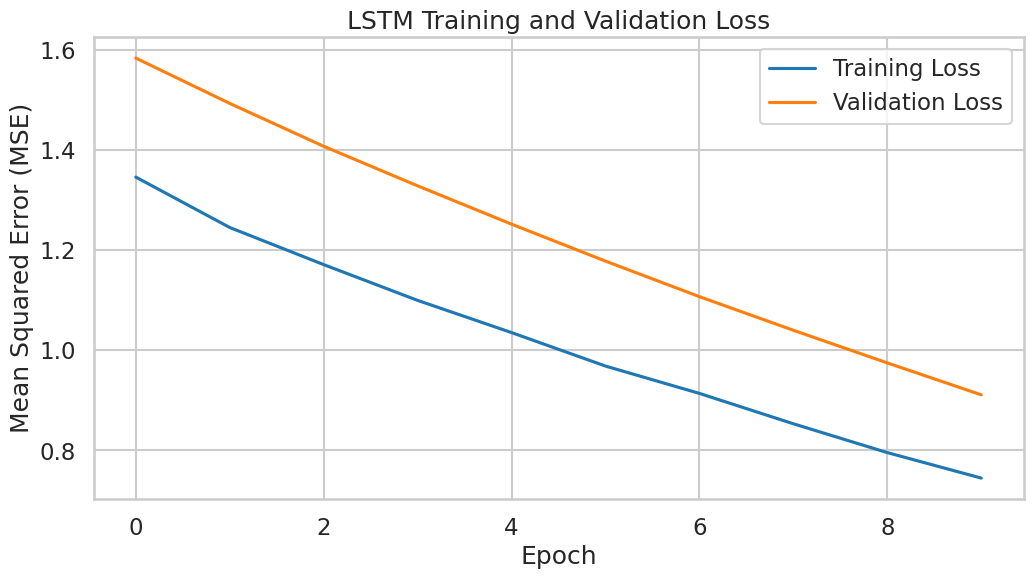

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(75, activation='relu', input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True))
model.add(LSTM(75, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Dense output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Plot the training and validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
X_june, Y_june_true = create_sequences(june_data, seq_length)
X_june = np.array(X_june);
Y_june_true = np.array(Y_june_true);
model.compile(optimizer='adam', loss='mse');
X_june.shape, Y_june_true.shape

((7, 15, 7), (7,))

In [35]:
predictions = model.predict(X_june, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


In [36]:
def reverse_scaling(data, scaler):
  if len(data.shape) == 1:
    data = data.reshape(-1, 1)

  dummy = np.zeros((len(data), len(features_to_normalize)))

  dummy[:, -1] = data.ravel()
  unscaled = scaler.inverse_transform(dummy)

  return unscaled[:, -1]

In [37]:
Y_june_true_unscaled = reverse_scaling(Y_june_true, scaler)
predictions_unscaled = reverse_scaling(predictions, scaler)

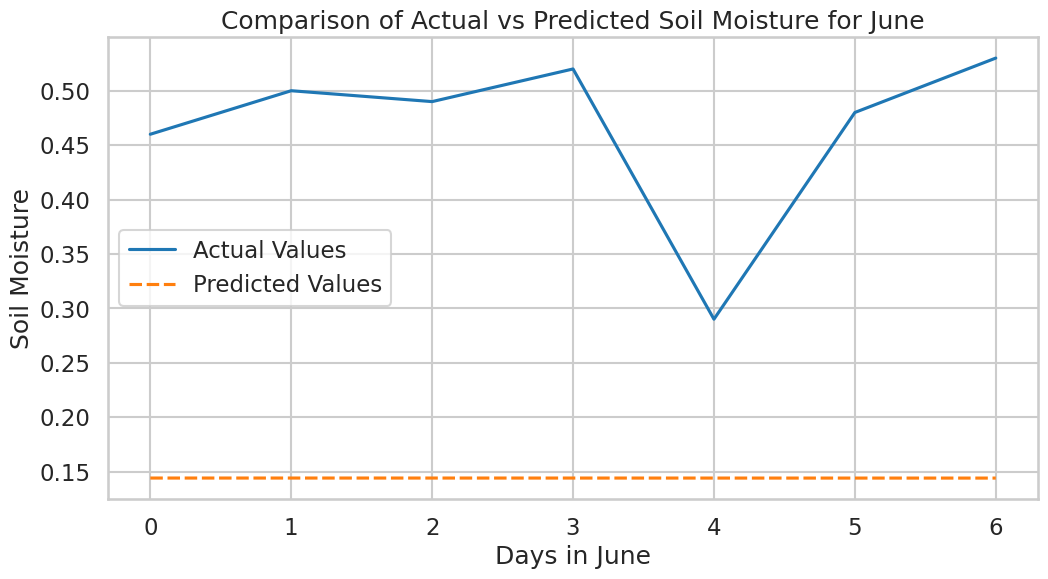

In [38]:
Y_june_true_unscaled = Y_june_true_unscaled.ravel()
predictions_unscaled = predictions_unscaled.ravel()

df_plot = pd.DataFrame({
    'Actual Values': Y_june_true_unscaled,
    'Predicted Values': predictions_unscaled
})

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot)
plt.title('Comparison of Actual vs Predicted Soil Moisture for June')
plt.ylabel('Soil Moisture')
plt.xlabel("Days in June")
plt.legend()
plt.show()

In [39]:
mae = np.mean(np.abs(Y_june_true_unscaled - predictions_unscaled))
print(f"Mean Absolute Error for June Predictions: {mae}")

Mean Absolute Error for June Predictions: 0.3231361118810518
